# Combining flats

There is one step in combining flats that is different from most other image
combination: the flats should be scaled to a common value before combining them.
This is particularly important if the flats are twilight flats in which the
average image value typically changes significantly as the images are being
taken.

Flats are typically grouped by filter when combining them. That is, one combined
flat is produced for each filter in which flats were taken.

Combination will be done for each of the two examples in the previous notebook.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ccdproc as ccdp
from astropy.stats import mad_std
from astropy.visualization import hist

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Example 1

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/203/files#diff-3583e2ea4cfc457912d1f1b9414e63b2R53){:target="_blank"}

We begin by setting up an image collection for the reduced data. This data is
from chip 0 of the cryogenically-cooled Large Format Camera at Palomar
Observatory.

In [3]:
calibrated_path = Path('example1-reduced')

flat_imagetyp = 'flatfield'

ifc = ccdp.ImageFileCollection(calibrated_path)

We'll first check what filters are present.

In [4]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

{"g'", "i'"}

These flats are dome flats, essentially pictures of a screen in the dome
illuminated by a light source, so you would not expect there to be much variable
in the typical pixel value between different exposures. There is typically
*some* variation, though, so we graph it below.

[20173.0, 20169.0, 20156.666666666668, 21026.0, 21042.333333333332, 21058.0]


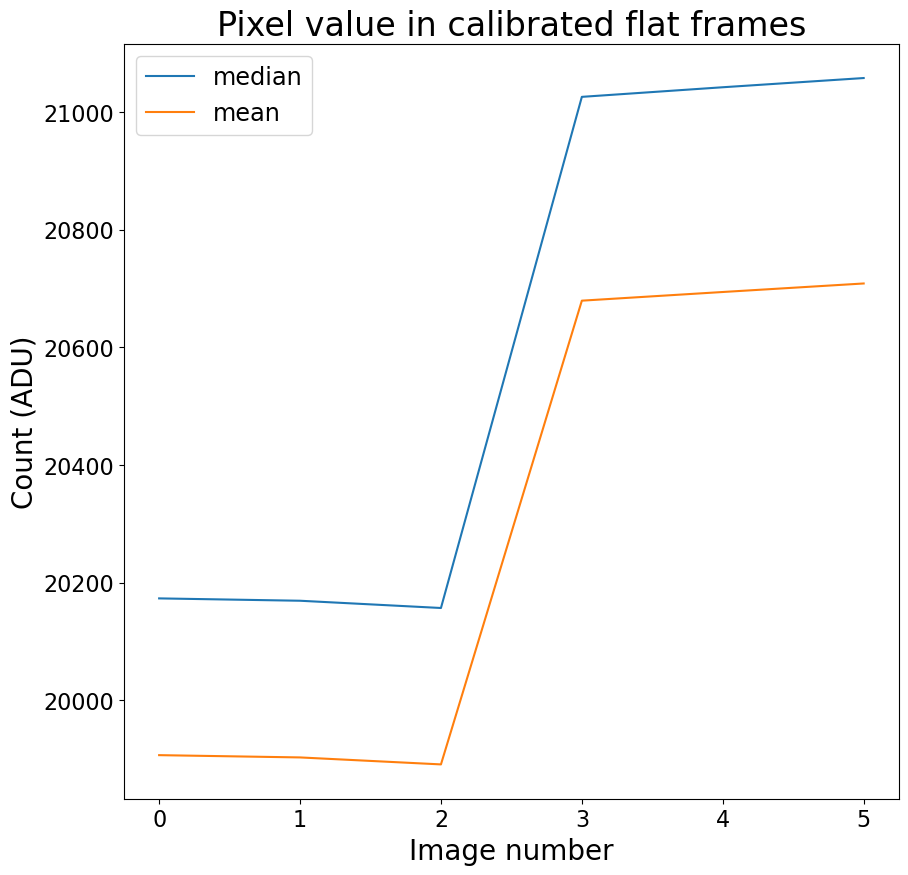

In [5]:
median_count = [np.median(data) for data in ifc.data(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in ifc.data(imagetyp=flat_imagetyp)]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

Although this is less frame-to-frame variation than we will see in Example 2, it
is about 5%. If we were to combine these without scaling the flats to a common
value then the images with higher counts would effectively get more weight than
the images.

There is a substantial difference between the mean and median of this data.
Typically it is better to use the median because extreme values do not affect
the median as much as the mean.

To scale the frames so that they have the same median value, we need to define a
function that can calculate the inverse of the median given the data.

In [6]:
def inv_median(a):
    return 1 / np.median(a)

This function is passed into the `scale` argument of `combine` below. One
combined flat is created for each filter in the data.

In [7]:
for filt in flat_filters:
    to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    dark_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Discussion of Example 1

We will begin by checking that the right number of combined flats have been
created. There were two filters, `g'` and `i'` in the raw data so there should
be two combined flats. We need to refresh the `ImageFileCollection` for the
reduced data because new files, our flats, have been added to them.

In [8]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(["combined_flat_filter_g'.fit", "combined_flat_filter_i'.fit"],
      dtype='<U27')

That looks good. The two flats are displayed below.

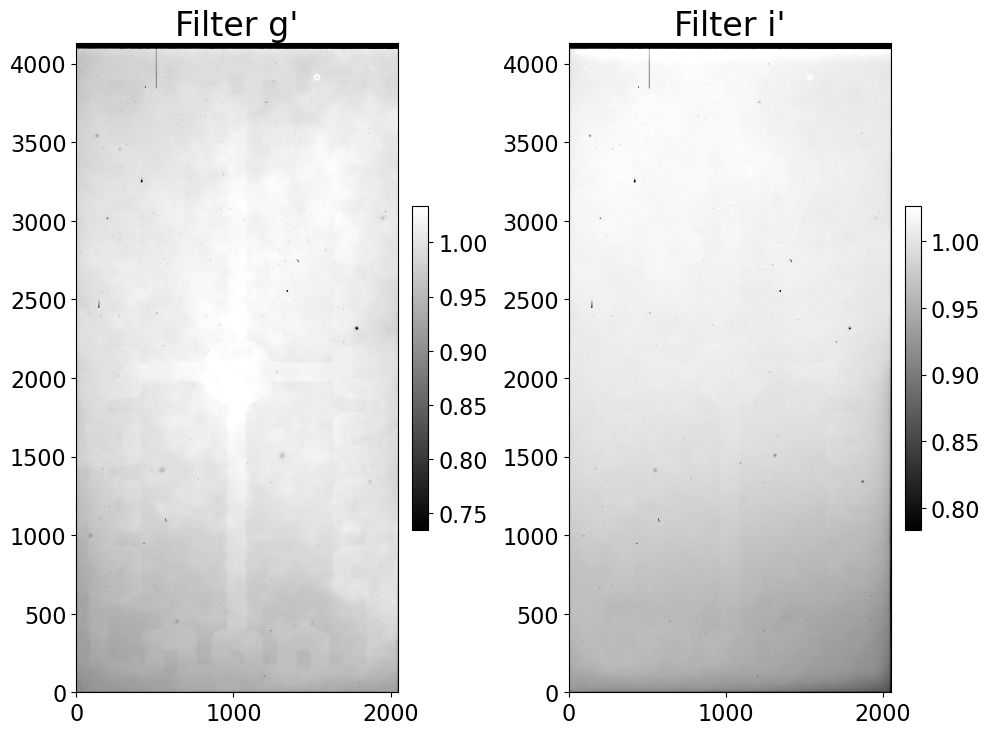

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20), tight_layout=True)

for ccd, axis in zip(ifc.ccds(imagetyp=flat_imagetyp, combined=True), axes):
    show_image(ccd.data, cmap='gray', fig=fig, ax=axis)
    title = "Filter {}".format(ccd.header['filter'])
    axis.set_title(title)

The first thing to notice is that the flats are different in these two filters.
That is expected because one of the elements in the optical path, the filter, is
different.

The pattern of electronics in the flat images is because this is a
backside-illuminated CCD. The light-detecting pixels are on the under side of
the chip and the light needs to pass through the chip to reach the sensor. The
small dark spots are places where the chip wasn't thinned uniformly.

Compare this with [Example 2](#Discussion-of-Example-2) below, which shows a flat
taken with a frontside-illuminated camera.

## Example 2

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/203/files#diff-3583e2ea4cfc457912d1f1b9414e63b2R241){:target="_blank"}

The data in this example is from a thermoelectrically-cooled Andor Aspen CG16M.
These flats are twilight flats, taken just after sunset.

In [10]:
calibrated_path = Path('example2-reduced')

flat_imagetyp = 'flat'

ifc = ccdp.ImageFileCollection(calibrated_path)

In [11]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

{'r'}

Twilight flats typically differ more frame-to-frame than dome flats, as
shown in the figure below.

[45891.90222222222, 44225.99888888889, 43128.94777777778, 41495.89333333333, 39871.95111111111, 39019.864, 38817.97997777778, 38863.88776666667, 38822.93813333334, 38661.95832222222]


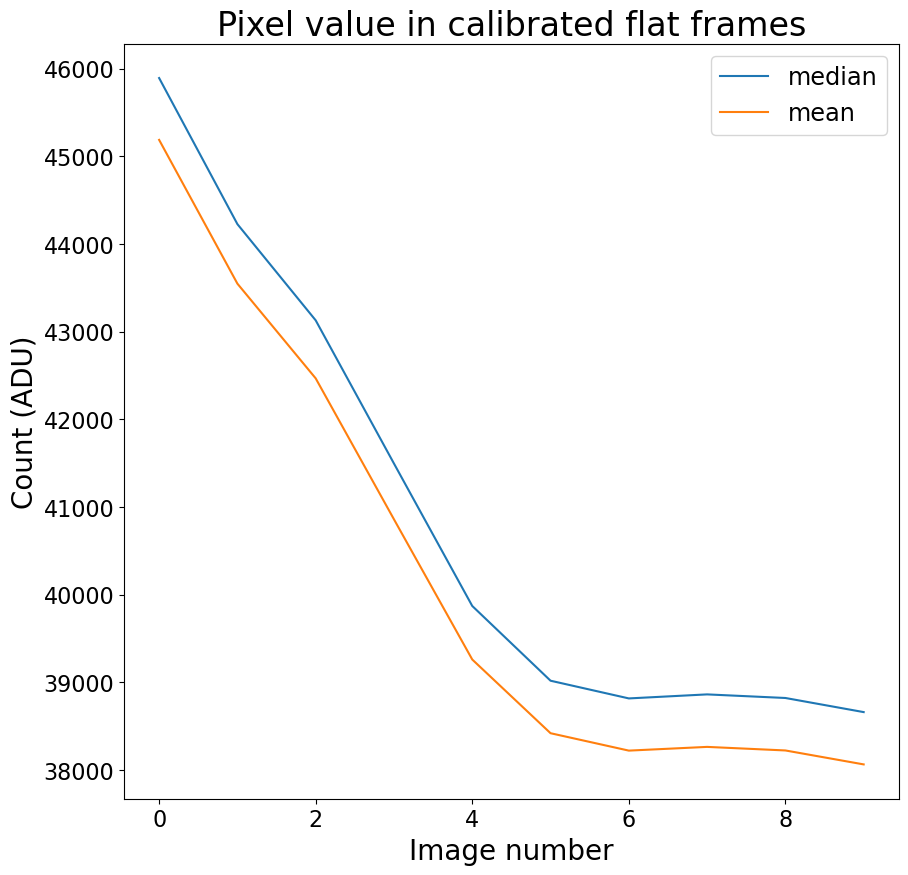

In [12]:
median_count = [np.median(hdu.data) for hdu in ifc.hdus(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in ifc.data(imagetyp=flat_imagetyp)]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

In [13]:
def inv_median(a):
    return 1 / np.median(a)

for filt in flat_filters:
    to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    dark_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_path / dark_file_name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Discussion of Example 2

We expect only one combined flat because there was only one filter. The
`ImageFileCollection` is refreshed before we query it because the combined flats
were added after the collection was created.

In [14]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(['combined_flat_filter_r.fit'], dtype='<U31')

The combined flat is displayed below.

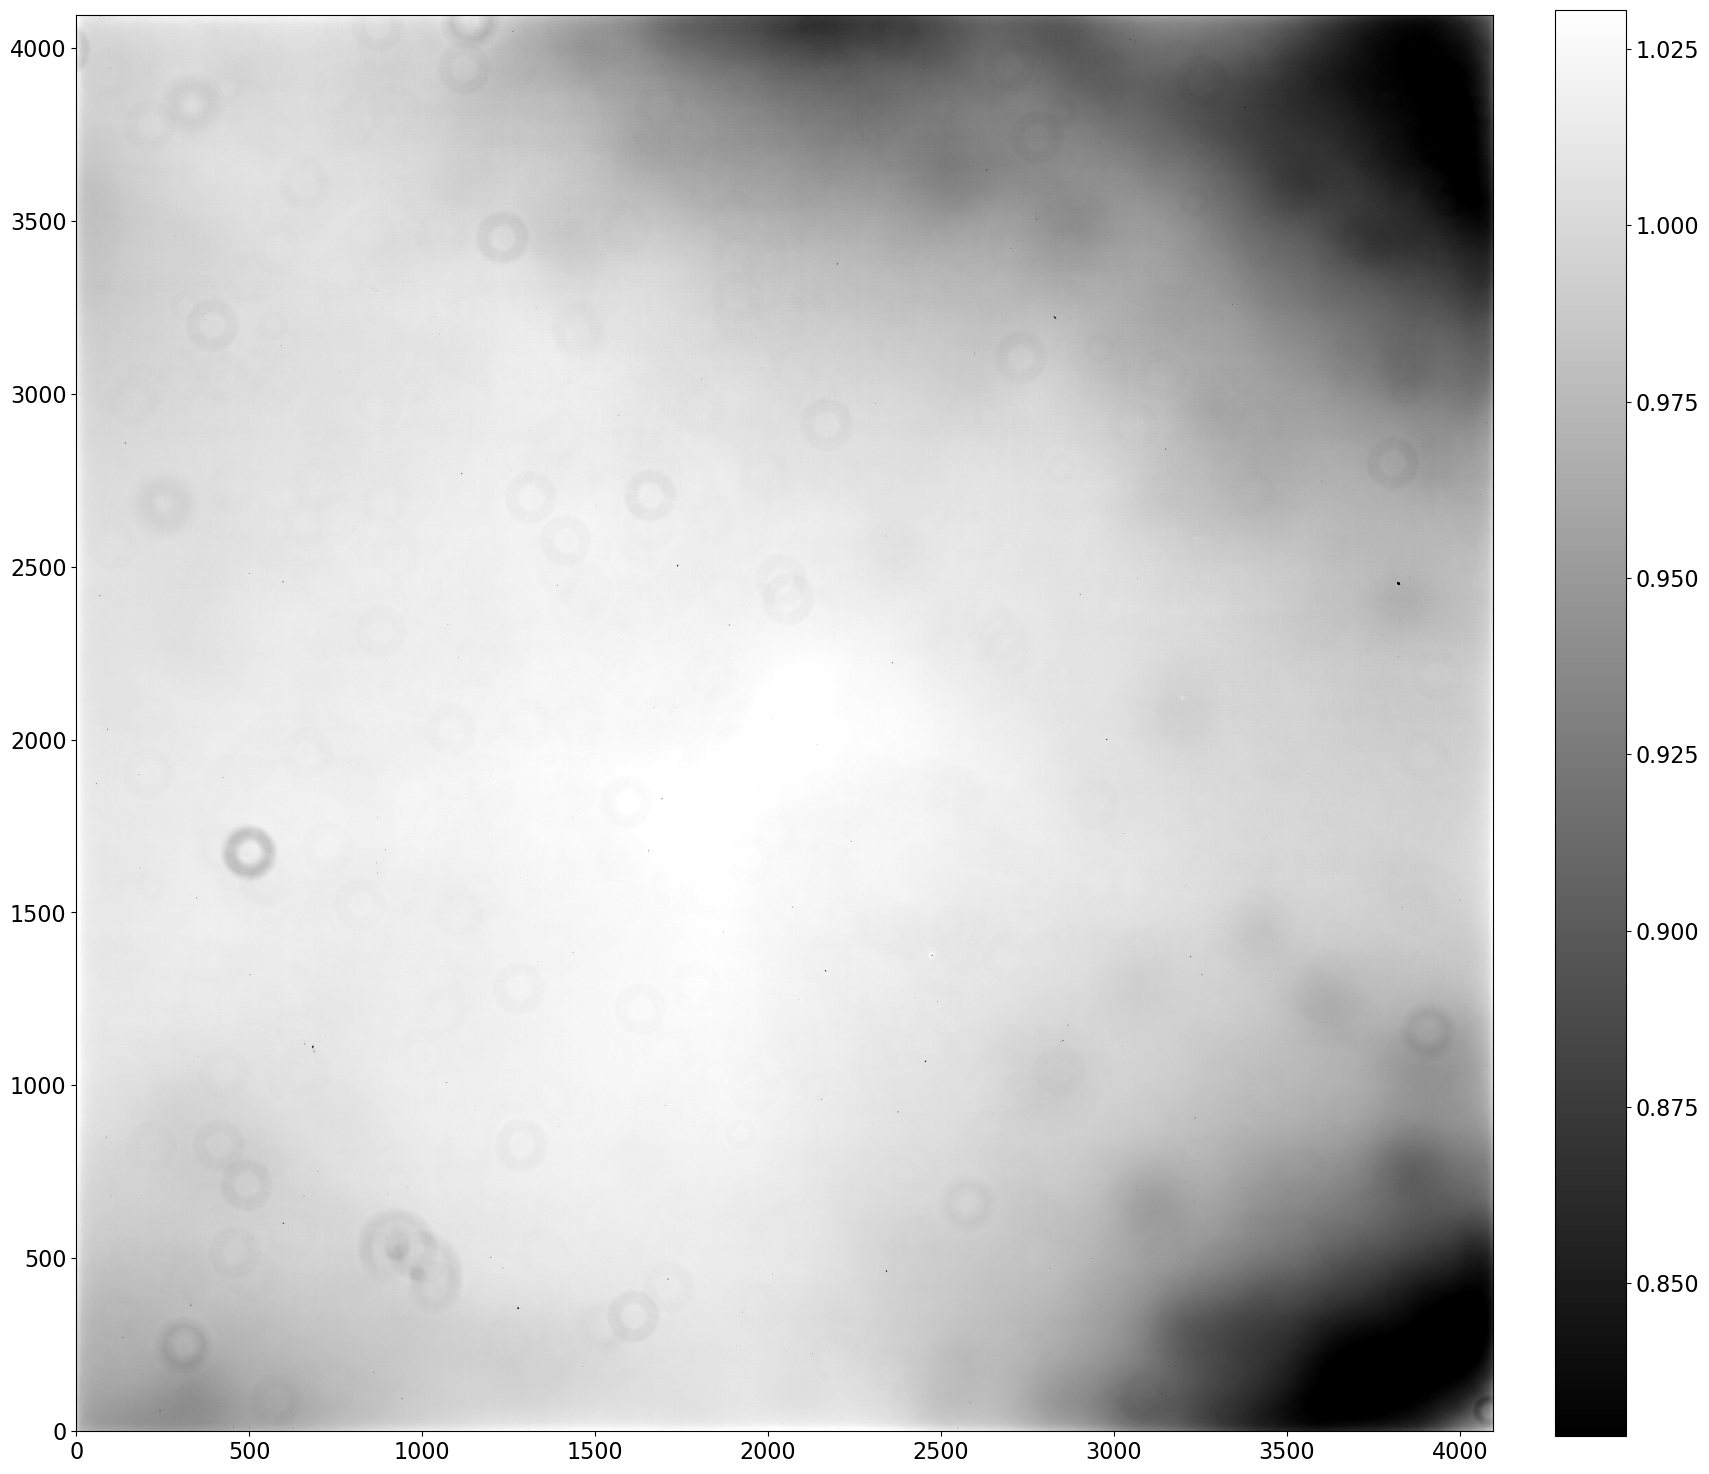

In [15]:
show_image(combined_flat, cmap='gray', figsize=(10, 20))

This flat looks very different than the one in [Example 1](#Discussion-of-Example-1)
because this CCD is frontside-illuminated and the previous one is backside-illuminated. 
That means the sensor is on the top of the chip and the light does
not pass through the sensor chip itself to reach the sensors. Though only one
filter is shown here, the flat field looks slightly different through other
filters on this camera.